In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from nltk import word_tokenize

/home/frfa/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/frfa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

# Preprocessing

Loading embeddings and defining preprocessing functions

In [191]:
### Load embeddings ###

# Google News
#import gensim.models
#googEmbs = gensim.models.KeyedVectors.load_word2vec_format(
#                                '../embeddings/googlenews.bin', binary=True)

# Glove 6B
glove_dict = {}
with open("../embeddings/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_dict[word] = vector
        
print('loading finished')

loading finished


In [192]:
# Preprocess function

def preprocessing(sentences, max_length=None):
    """
    Inputs sequence of strings (predictor). Outputs data as word embeddings with fixed length and tensor format.
    
    max_length defines maximum length of sentences. Too short sentences will be padded, and too long sentences will be cut.
    If not defined, all sentences will be the length of the longest.
    """
    
    cleaned_sentence = []
    sent_length = 0
    
    for sentence in sentences:
        sentence = word_tokenize(sentence) # Preprocessing step: Tokenize
        emb_sent = []
        
        for word in sentence: # Convert each word into embedding or zero vector
            
            try:
                emb_word = glove_dict[word.lower()]
            except KeyError:
                emb_word = np.zeros((50,)) 
            emb_sent.append(emb_word)
            
        if len(emb_sent) > sent_length:
            sent_length = len(emb_sent)
        cleaned_sentence.append(emb_sent)
        
    # Padding to longest sentence length -- Or max length variable if defined
    if not max_length:
        max_length = sent_length
        
    # Padding to longest sentence length
    for idx, cleaned_sent in enumerate(cleaned_sentence):
        if len(cleaned_sent) < max_length:
            for i in range(max_length - len(cleaned_sent)):
                cleaned_sent.append(np.zeros((50,)))
        if len(cleaned_sent) > max_length:
            cleaned_sentence[idx] = cleaned_sentence[idx][:max_length]
            
    
    return torch.tensor(cleaned_sentence) # a tensor of data. Each index is an instance

In [193]:
def binary_y(y):
    """
    Converts sequence of string labels to binary 1 for positive and 0 for negative tensor.
    """
    
    for i in range(len(y)):
        if y[i] == "positive":
            y[i] = 1
        if y[i] == "negative":
            y[i] = 0
            
    return torch.tensor(y)

# Loading the data

Loading the data and converting it via preprocessing functions. Batching will be done in the <b>Training</b>-section.

In [194]:
# Loading train, dev and test data
from loader import load_train, load_dev, load_test
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train = load_train()
dev = load_dev()
test = load_test()

In [195]:
train_x = preprocessing(train["reviewText"][:5000], max_length=60)
train_y = binary_y(train["sentiment"][:5000])
all_train = TensorDataset(train_x, train_y)

dev_x = preprocessing(dev["reviewText"][:10000], max_length=60)
dev_y = binary_y(dev["sentiment"][:10000])
all_dev = TensorDataset(dev_x, dev_y)

#test_x = preprocessing(test["reviewText"][:100], 20)
#test_y = test["sentiment"][:100]

# Defining the NN Model

A GRU NN with a FFNN layer on top

In [204]:
# Hyperparameters

# Network
input_size = train_x.shape[2]
hidden_size = 300
num_layers = 2
sequence_length = train_x.shape[1]

# Training
learning_rate = 0.005
momentum = 0.9
batch_size = 50
num_epoch = 30

In [205]:
class sentiNN(nn.Module):
    """ 
    Neural Network for sentiment analysis. GRU model with binary classification FFNN on top.
    """
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(sentiNN, self).__init__()
        
        # Variables / parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Layers
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size * sequence_length, 100)
        self.fc2 = nn.Linear(100, out_features=2)
        
    def forward(self, x):        
        # Initialize GRU hidden state
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        #print("h0")
        #print(h0.shape)
        #print(h0)
        #print("\n")
        #print("x")
        #print(x.shape)
        #print(x)
        
        # Forward Prop
        out, _ = self.gru(x) #, h0)
        out = out.reshape(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out
    

In [206]:
net = sentiNN(input_size, hidden_size, num_layers).float()

# Training the NN

In [207]:
# Batching the data

train_batches = DataLoader(all_train, batch_size=batch_size)
dev_batches = DataLoader(all_dev, batch_size=batch_size)

In [208]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [209]:
loss_list = []

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_batches, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_list.append(running_loss)
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.661
[2,   100] loss: 0.624
[3,   100] loss: 0.606
[4,   100] loss: 0.585
[5,   100] loss: 0.558
[6,   100] loss: 0.548
[7,   100] loss: 0.529
[8,   100] loss: 0.533
[9,   100] loss: 0.514
[10,   100] loss: 0.515
[11,   100] loss: 0.503
[12,   100] loss: 0.493
[13,   100] loss: 0.481
[14,   100] loss: 0.474
[15,   100] loss: 0.466
[16,   100] loss: 0.457
[17,   100] loss: 0.449
[18,   100] loss: 0.441
[19,   100] loss: 0.433
[20,   100] loss: 0.426
[21,   100] loss: 0.418
[22,   100] loss: 0.410
[23,   100] loss: 0.402
[24,   100] loss: 0.394
[25,   100] loss: 0.386
[26,   100] loss: 0.378
[27,   100] loss: 0.368
[28,   100] loss: 0.358
[29,   100] loss: 0.349
[30,   100] loss: 0.338
Finished Training


# Plotting training progress

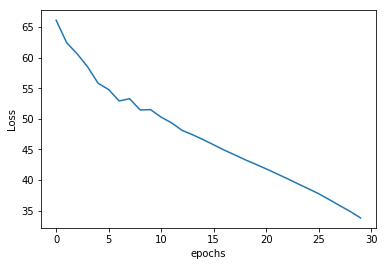

In [212]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(len(loss_list))], loss_list)
#plt.axis([0, 1, 0, 20])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()

# (OLD) Loading and preprocessing the data

Using torchtext: 
- https://torchtext.readthedocs.io/en/latest/index.html
- https://galhever.medium.com/sentiment-analysis-with-pytorch-part-1-data-preprocessing-a51c80cc15fb
- https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb

In [ ]:
# Loading train data

from loader import load_train
train = load_train()

In [ ]:
# Preprocessing data

from torchtext.legacy import data
import spacy 

#spacy.cli.download("en_core_web_sm")

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  #preprocessing=preprocessing,
                  fix_length=200, # should be max_document_length
                  lower=True
                 )
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
# Formating train_x and train_y

train_x = list(map(TEXT.preprocess, train["reviewText"]))
train_x = TEXT.pad(train_x)
train_y = list(map(LABEL.preprocess, train["sentiment"]))

In [ ]:
# Building vocab

TEXT.build_vocab(train_x, max_size=5000, vectors='glove.42B.300d')
LABEL.build_vocab(train_x)
vocab_size = len(TEXT.vocab)

In [ ]:
vocab = TEXT.vocab

In [ ]:
vocab["hope"]